Enter the population P of the environment: 10
Enter the parent selection rate mu: 0.4
Enter the inheritance rate lamba (1-Mu): 0.6
Enter the number of times each city to be visited: 2
Enter the maximum number of generations: 70
Do you want to select the longest/shortest route?
Enter 1 for longest or Enter 0 for shortest): 1


------------------Output of the evolutionary algorithm--------------
The total length of the path found: 38522 units


Resulting sequence of co-ordinates: 
627	831
1012	473
1062	966
477	798
860	571
732	942
755	884
686	420
477	798
1012	473
712	897
578	900
927	780
1115	1116
720	786
860	571
378	727
51	960
328	913
146	147
578	960
578	900
830	921
720	786
350	636
657	840
592	535
940	667
1062	966
179	947
456	896
830	921
940	667
569	400
623	1150
523	792
663	768
752	977
350	636
755	884
786	487
146	147
430	671
927	780
592	535
686	420
328	913
458	707
606	627
794	411
51	960
720	786
456	896
857	1071
1012	473
328	913
249	548
350	636
578	960
430	671
732	942
663	768
1062	966
378	

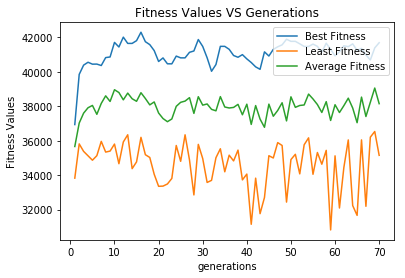

In [1]:
import sys, random
import numpy
from math import sqrt, ceil
from PIL import Image, ImageDraw, ImageFont
import time
import re
import matplotlib.pyplot as plt
%matplotlib inline


# function to find distance matrix wrt. each co-ordinates
def get_distance_matrix(coords):
    matrix = {}
    for i, (x1, y1) in enumerate(coords):
        for j, (x2, y2) in enumerate(coords):
            dx = x1 - x2
            dy = y1 - y2
            dist = sqrt(dx*dx + dy*dy)
            matrix[i, j] = dist
    return matrix

# function get the co-ordinates of the cities as key(city_index): value(co-ordinates) pairs
def get_cities_coords(num_cities,cities):
    coords = []
    city_coords = {}
    for i in range(1,num_cities+1):
        city = str(cities[i])
        
        city = re.sub(r'(^[ \t]+|[ \t]+)', '',city)
        city_info = re.findall(r'\d+',city)
        
        city_coords[city_info[0]] = (int(city_info[1]), int(city_info[2])) 

        coords.append( (float(city_info[1]), float(city_info[2])) )
    return city_coords, coords

# function to calculate the fitness function
def eval_func(chromosome):
    """ 
    The evaluation function 
    """
    global cm
    return get_route_length(cm, chromosome)


cm = []
coords = []

class Individual:
    distance = 0 

    def __init__(self, visits, chromosome=None):
        self.visits = visits
        self.chromosome = self._makechromosome()
        self.distance = 0

    def _makechromosome(self):
        """
        Makes a chromosome from randomly selected alleles
        if each city has to be visited twice:
            chromosome will be generated such that an array of city index is 
            generated twice. Ex: [0,0,1,1,2,2,3,3]
            and then reshuffled in random order Ex: [0,3,1,0,2,3,1,2]
        """
        chromosome = [i for i in range(num_cities) for _ in range(self.visits)]
        random.shuffle(chromosome)
        return chromosome

    def evaluate(self):	
        """
        Calculates length of a route for current individual
        """		
        self.distance = self.get_route_length()

    def crossover(self, other):
        """
        Cross two parents and returns created child's
        """
        left, right = self._pickpivots(self.visits)
        c = Individual(self.visits)
        c.chromosome = self.chromosome[0:left]
        c.chromosome.extend(other.chromosome[left:right])
        c.chromosome.extend(self.chromosome[right:])
        return c

    def mutate(self):
        """ 
        Swap two elements 
        """
        left, right = self._pickpivots(self.visits)        
        self.chromosome[left], self.chromosome[right] = self.chromosome[right], self.chromosome[left]


    def _pickpivots(self,visits):
        """
        Returns random left, right pivots 
        """
        left = random.randint(0, (num_cities*visits) - 2)
        right = random.randint(left, (num_cities*visits) - 1)
        
        return left, right


    def get_route_length(self):
        """
        Returns the total length of the route
        """
        total = 0
        global cm
        
        for i in range(len(self.chromosome)):
            j = (i + 1) % len(self.chromosome)
            city_from = self.chromosome[i]

            city_to = self.chromosome[j]

            total += cm[city_from, city_to]

        return total
    
        

class Environment:
    size = 0

    def __init__(self, P, Mu, lamda, nVisits, maxgenerations,selectedRoute):
        self.size = P
        self.visits = nVisits
        self.population = self._makepopulation()
        self.maxgenerations = maxgenerations
        self.selection_rate = Mu
        self.inheritance_rate = lamda
        self.generation = 0
        
        self.route = selectedRoute
        self.parents = []

    # initialize the population
    def _makepopulation(self):
        return [Individual(self.visits) for i in range(0, self.size)]

    def run(self,city_info):
        BestFitness = []
        LeastFitness = []
        AvgFitness = []
        
        # for each generation perform
        for i in range(0, self.maxgenerations):
            
            self.newPopulation = []
            self.distances = []
            
            # for each individual in the generation perform 
            for j in range(0, self.size):
                # evaluate the fitness function of each individual
                self.population[j].evaluate()
                
                # find the length of the route of each individual
                curscore = self.population[j].distance
                self.distances.append(curscore)
            
            # length of the route of each individual as fitness values
            fitnessValues = list(self.distances)
            
            # find the best, least and average length of the route among the
            # population of the generation
            BestFitness.append(max(fitnessValues))
            LeastFitness.append(min(fitnessValues)) 
            AvgFitness.append(sum(fitnessValues) / float(len(fitnessValues)))

            # find the number of parents to be selected among the population
            n_parents = int(round(self.selection_rate * self.size ))
            
            # select the best individuals as parents for crossover
            # when longest route is selected then self.route -> 1
            # when shortest route is selected then self.route -> 0
            for i in range(0, n_parents):
                # find longest route
                if (self.route):
                    max_fitValue = max(self.distances)                   
                    max_index = self.distances.index(max_fitValue)
                    self.parents.append(self.population[max_index])
                    self.newPopulation.append(self.population[max_index])
                    self.population.pop(max_index)
                    self.distances.pop(max_index)

                else:
                    # find shortest route
                    min_fitValue = min(self.distances)                    
                    min_index = self.distances.index(min_fitValue)
                    self.parents.append(self.population[min_index])
                    self.newPopulation.append(self.population[min_index])
                    self.population.pop(min_index)
                    self.distances.pop(min_index)
            
            # find the number of children to be generated 
            n_children = int(round(self.inheritance_rate * self.size ))
            
            # select k=2 parents for cross-over among the best parents
            parentsIndex = [i for i in range(n_parents)] 
            random.shuffle(parentsIndex)
            
            # k1-> index of parent 1
            # k2-> index of parent 2
            k1 = 0
            k2 = 0
            for i in range(0, n_children):                
                k2 = (i + 1) % n_parents
                child = self.parents[parentsIndex[k1]].crossover(self.parents[parentsIndex[k2]])
                self.newPopulation.append(child)
                k1 += k1
            
            # mutation
            for i in range(0, len(self.newPopulation)):
                self.newPopulation[i].mutate()
            
            # new population consists of selected parents, generated children, mutated individuals
            self.population = self.newPopulation
        
        # find the best route wrt. selection criteria
        max_fitValue = max(list(self.distances))
        print("The total length of the path found: {} units".format(str(int(max_fitValue))))
        print('\n')
        max_index = self.distances.index(max_fitValue)
        MaxRouteIndividual = self.population[max_index]
        sequenceOfRoutes = list(MaxRouteIndividual.chromosome)
        
        print("Resulting sequence of co-ordinates: ")
        
        for start in range(len(sequenceOfRoutes)):
            cityIndex = sequenceOfRoutes[start]
            co_ord = city_info.get(str(cityIndex+1))
            print(co_ord[0],co_ord[1],sep = '\t')
            
        
        generations = numpy.linspace(1.0, self.maxgenerations, self.maxgenerations)
        
        fig_a = plt.figure()
        fig1 = fig_a.add_subplot(111)
        fig1.plot(generations, BestFitness, label = 'Best Fitness')
        fig1.plot(generations, LeastFitness, label = 'Least Fitness')
        fig1.plot(generations, AvgFitness, label = 'Average Fitness')
        fig1.legend(loc='upper right')
        plt.xlabel("generations")
        plt.ylabel("Fitness Values")
        plt.title("Fitness Values VS Generations")
        
        
dist_matrix = []
cities = []
max_nCities = 150
def main_run():
    global cm, coords, num_cities

    # open the text file
    f = open('Positions_PA-F.txt', 'r')
    for line in f:        
        cities.append(format(line.strip('#').split('#')))
    
    num_cities = len(cities)-1
    
    # if number of cities greater than 150
    if(num_cities>max_nCities):
        num_cities = max_nCities
    
    # get city co-ordinates as key-value pair
    city_info, coords = get_cities_coords(num_cities,cities)	
    
    # get the distance matrix from each city to other
    cm = get_distance_matrix(coords)

    P = int(input("Enter the population P of the environment: "))
    
    Mu = float(input("Enter the parent selection rate mu: "))
    
    lamda = float(input("Enter the inheritance rate lamba (1-Mu): "))
    
    nVisits = int(input("Enter the number of times each city to be visited: "))
    
    max_nGenerations = int(input("Enter the maximum number of generations: "))
    
    print("Do you want to select the longest/shortest route?")
    selectedRoute = int(input("Enter 1 for longest or Enter 0 for shortest): "))
    print('\n')
    print("------------------Output of the evolutionary algorithm--------------")

    
    ev = Environment(P, Mu, lamda, nVisits, max_nGenerations, selectedRoute)
    ev.run(city_info)
    

if __name__ == '__main__':
	main_run()